# Cyclone Eye Detection - Improved Model

## Issues Fixed:
1. **Label Extraction**: Fixed to use channel 3 (mask) instead of channel 2 (NaN values)
2. **Model Architecture**: 
   - Unfroze last 30 layers for fine-tuning
   - Added BatchNormalization layers
   - Improved regression head (1024→512→256 neurons)
   - Changed output activation to sigmoid (since labels are normalized)
3. **Training Improvements**:
   - Added data augmentation (rotation, shifts)
   - Used Huber loss (more robust than MSE)
   - Added learning rate scheduling
   - Better callbacks (ReduceLROnPlateau, EarlyStopping)
4. **Evaluation**: Added distance error metrics and better visualizations

## Expected Improvements:
- More accurate eye center predictions
- Better generalization
- Reduced prediction errors


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf


In [2]:
import h5py

dataset_path = 'cyclone_dataset.h5'

def print_structure(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"📂 Dataset: {name} — shape: {obj.shape}")
    elif isinstance(obj, h5py.Group):
        print(f"📁 Group: {name}")

with h5py.File(dataset_path, 'r') as f:
    print("🔍 Structure of the HDF5 file:\n")
    f.visititems(print_structure)


🔍 Structure of the HDF5 file:

📁 Group: info
📂 Dataset: info/axis0 — shape: (8,)
📂 Dataset: info/axis1 — shape: (4580,)
📂 Dataset: info/block0_items — shape: (5,)
📂 Dataset: info/block0_values — shape: (4580, 5)
📂 Dataset: info/block1_items — shape: (3,)
📂 Dataset: info/block1_values — shape: (1,)
📂 Dataset: matrix — shape: (4580, 201, 201, 4)


In [3]:
import h5py
import numpy as np

dataset_path = 'cyclone_dataset.h5'

with h5py.File(dataset_path, 'r') as f:
    data = np.array(f['matrix'])

print("Matrix shape:", data.shape)
print("Data type:", data.dtype)

# Show one example
sample = data[0]
print("Single sample shape:", sample.shape)

# Check unique values or ranges
print("Channel means:", [np.mean(sample[:,:,i]) for i in range(4)])


Matrix shape: (4580, 201, 201, 4)
Data type: float32
Single sample shape: (201, 201, 4)
Channel means: [np.float32(262.8639), np.float32(236.72902), np.float32(nan), np.float32(0.971902)]


In [4]:
import numpy as np

# Use channels 0,1,3 as image input (ignore channel 2 which has NaN)
# Note: Channel indices are [0,1,3] but we need to map correctly
# data[:,:,:,0] = channel 0, data[:,:,:,1] = channel 1, data[:,:,:,3] = channel 3
images = data[:,:,:, [0,1,3]]

# Normalize image values properly (per-channel normalization for better stability)
# Clip extreme values first
for i in range(3):
    channel = images[:,:,:,i]
    channel = np.clip(channel, 0, np.percentile(channel[~np.isnan(channel)], 99.9))
    images[:,:,:,i] = channel / np.max(channel[~np.isnan(channel)])

# Prepare labels — find the cyclone eye center from channel 3 (the mask channel)
def find_eye_center(mask):
    """
    Find the cyclone eye center from the mask channel.
    The mask has values > 0 where the eye is located.
    We'll use a threshold to find the eye region and compute the centroid.
    """
    # Remove NaN values
    mask_clean = np.nan_to_num(mask, nan=0.0)
    
    # Use threshold to find eye region (values significantly above zero)
    threshold = np.percentile(mask_clean[mask_clean > 0], 50) if np.count_nonzero(mask_clean > 0) > 0 else 0.1
    eye_mask = mask_clean > threshold
    
    if np.count_nonzero(eye_mask) == 0:
        # If no eye found, try lower threshold
        if np.count_nonzero(mask_clean > 0.01) > 0:
            eye_mask = mask_clean > 0.01
        else:
            # Fallback: return center of image
            return np.array([100.5, 100.5])
    
    # Calculate centroid (weighted by mask values for better accuracy)
    y_coords, x_coords = np.where(eye_mask)
    if len(x_coords) == 0:
        return np.array([100.5, 100.5])
    
    # Weight by mask intensity
    weights = mask_clean[y_coords, x_coords]
    if np.sum(weights) > 0:
        x_center = np.average(x_coords, weights=weights)
        y_center = np.average(y_coords, weights=weights)
    else:
        x_center = np.mean(x_coords)
        y_center = np.mean(y_coords)
    
    return np.array([x_center, y_center])

# Extract labels from channel 3 (index 3, which is the 4th channel)
labels = np.array([find_eye_center(data[i,:,:,3]) for i in range(len(data))])

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Example label (x,y):", labels[0])
print("Label statistics:")
print(f"  X range: [{np.min(labels[:,0]):.2f}, {np.max(labels[:,0]):.2f}]")
print(f"  Y range: [{np.min(labels[:,1]):.2f}, {np.max(labels[:,1]):.2f}]")
print(f"  X mean: {np.mean(labels[:,0]):.2f}, Y mean: {np.mean(labels[:,1]):.2f}")


c:\Users\beast\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Images shape: (4580, 201, 201, 3)
Labels shape: (4580, 2)
Example label (x,y): [133.53310685 106.17640663]
Label statistics:
  X range: [9.58, 200.00]
  Y range: [0.00, 188.61]
  X mean: 108.81, Y mean: 95.43


In [5]:
# Normalize labels (x, y) to 0–1 range for stable regression
# This helps the model learn better since coordinates are in [0, 1] range
labels_norm = labels / 201.0

# Verify normalization
print("Normalized label statistics:")
print(f"  X range: [{np.min(labels_norm[:,0]):.4f}, {np.max(labels_norm[:,1]):.4f}]")
print(f"  Y range: [{np.min(labels_norm[:,1]):.4f}, {np.max(labels_norm[:,1]):.4f}]")
print(f"  Mean: [{np.mean(labels_norm[:,0]):.4f}, {np.mean(labels_norm[:,1]):.4f}]")


Normalized label statistics:
  X range: [0.0477, 0.9384]
  Y range: [0.0000, 0.9384]
  Mean: [0.5414, 0.4748]


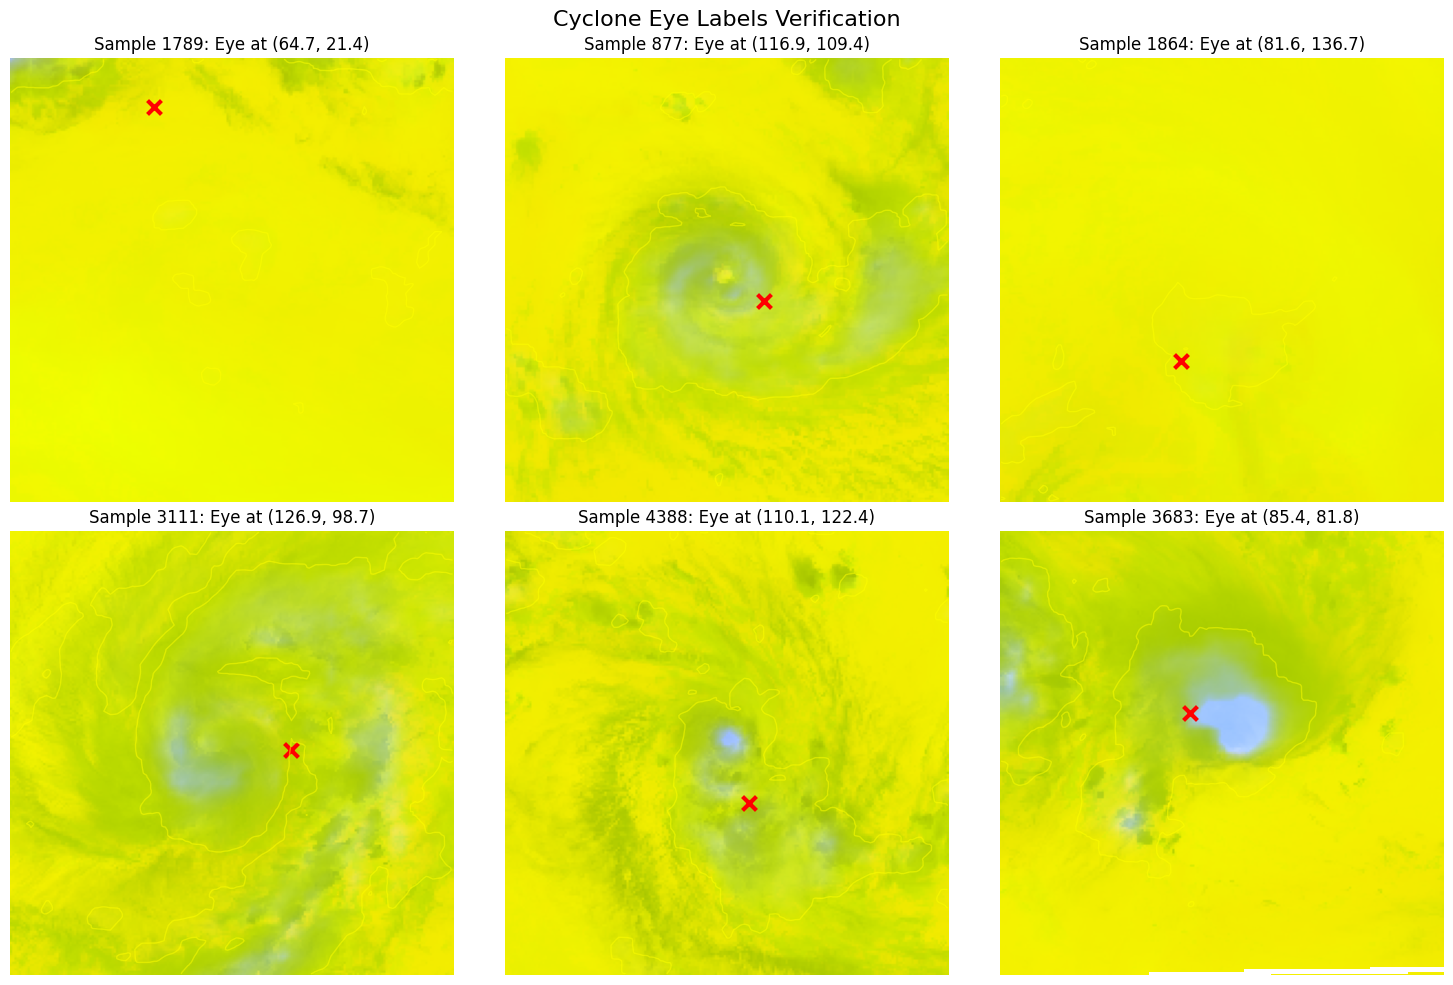


✅ Verified 6 random samples. Labels should be at the center of the yellow contours.


In [6]:
import matplotlib.pyplot as plt

# Visualize multiple examples to verify labels are correct
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(6):
    i = np.random.randint(0, len(images))
    img = images[i]
    x, y = labels[i]
    
    # Also show the mask channel for verification
    mask = data[i,:,:,3]
    
    axes[idx].imshow(img)
    axes[idx].scatter(x, y, color='red', s=100, marker='x', linewidths=3, label='Eye Center')
    axes[idx].set_title(f"Sample {i}: Eye at ({x:.1f}, {y:.1f})")
    axes[idx].axis('off')
    
    # Overlay mask contours
    mask_clean = np.nan_to_num(mask, nan=0.0)
    if np.count_nonzero(mask_clean > 0.1) > 0:
        axes[idx].contour(mask_clean, levels=[0.1], colors='yellow', linewidths=1, alpha=0.5)

plt.suptitle("Cyclone Eye Labels Verification", fontsize=16)
plt.tight_layout()
plt.show()

print(f"\n✅ Verified {6} random samples. Labels should be at the center of the yellow contours.")


In [7]:
from sklearn.model_selection import train_test_split

# Use normalized labels for training
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    images, labels_norm, test_size=0.2, random_state=42, shuffle=True
)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print(f"\nTraining label range: X=[{np.min(y_train[:,0]):.3f}, {np.max(y_train[:,0]):.3f}], Y=[{np.min(y_train[:,1]):.3f}, {np.max(y_train[:,1]):.3f}]")
print(f"Validation label range: X=[{np.min(y_val[:,0]):.3f}, {np.max(y_val[:,0]):.3f}], Y=[{np.min(y_val[:,1]):.3f}, {np.max(y_val[:,1]):.3f}]")


Training samples: 3664
Validation samples: 916

Training label range: X=[0.048, 0.995], Y=[0.000, 0.894]
Validation label range: X=[0.073, 0.995], Y=[0.121, 0.938]


In [8]:
# ============================================================================
# OPTIONAL: Load a previously saved model
# ============================================================================
# SKIP THIS CELL if you want to train a new model from scratch
# Only run this if you want to use an existing trained model without retraining

from tensorflow.keras.models import load_model

LOAD_EXISTING_MODEL = False  # Set to True to load existing model, False to build new one

if LOAD_EXISTING_MODEL:
    try:
        model = load_model('best_resnet50_model.h5')
        print("✅ Model loaded successfully from 'best_resnet50_model.h5'")
        print(f"Model input shape: {model.input_shape}")
        print(f"Model output shape: {model.output_shape}")
        print("\n⚠️  Note: If you want to retrain, set LOAD_EXISTING_MODEL = False")
    except Exception as e:
        print(f"⚠️  Could not load model: {e}")
        print("Will build new model in Cell 9.")
        LOAD_EXISTING_MODEL = False
else:
    print("⏭️  Skipping model loading. Will build new model in Cell 9.")
    print("   (Set LOAD_EXISTING_MODEL = True if you want to load existing model)")


⏭️  Skipping model loading. Will build new model in Cell 9.
   (Set LOAD_EXISTING_MODEL = True if you want to load existing model)


In [12]:
# ============================================================================
# Build Model Architecture
# ============================================================================
# This cell builds the model. It will build a new model unless one was loaded in Cell 8.

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Check if model already exists and was loaded from Cell 8
should_build_model = True
if 'model' in globals():
    # Check if it was loaded (not built)
    if 'LOAD_EXISTING_MODEL' in globals() and LOAD_EXISTING_MODEL:
        print("✅ Model already loaded from Cell 8. Skipping model building.")
        print("   If you want to rebuild, set LOAD_EXISTING_MODEL = False in Cell 8 and rerun both cells.")
        should_build_model = False
    else:
        print("⚠️  Model variable exists but wasn't loaded. Rebuilding...")
        should_build_model = True

if should_build_model:
    print("🔨 Building new model architecture...")
    
    input_shape = X_train.shape[1:]  # (201, 201, 3)

    # Load ResNet50 backbone (pretrained on ImageNet)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Unfreeze the last few layers for fine-tuning (this improves accuracy significantly)
    # Freeze early layers, unfreeze later layers
    for layer in base_model.layers[:-30]:  # Freeze all except last 30 layers
        layer.trainable = False
    for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
        layer.trainable = True

    print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}/{len(base_model.layers)}")

    # Add improved custom regression head with better architecture
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(2, activation='sigmoid')(x)  # Use sigmoid since labels are normalized to [0,1]

    model = Model(inputs=base_model.input, outputs=output)

    # Use Huber loss which is more robust to outliers than MSE
    # Also add learning rate schedule
    initial_lr = 1e-4
    model.compile(
        optimizer=Adam(learning_rate=initial_lr, beta_1=0.9, beta_2=0.999),
        loss=Huber(delta=0.1),  # Huber loss is more robust than MSE
        metrics=['mae', 'mse']  # Track both MAE and MSE
    )

    model.summary()
    print("\n✅ Model built successfully!")
    print(f"✅ Model is ready for training! Total parameters: {model.count_params():,}")


🔨 Building new model architecture...
Trainable layers: 30/175


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 201, 201,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 207, 207,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 101, 101,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 101, 101,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 101, 101,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 103, 103,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 51, 51,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 51, 51,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 51, 51,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 51, 51,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 51, 51,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 51, 51,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 51, 51,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 51, 51,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 51, 51,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 51, 51,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 51, 51,    │      1,024 │ conv2_block1_3_c

 Total params: 26,348,674 (100.51 MB)

 Trainable params: 17,208,066 (65.64 MB)

 Non-trainable params: 9,140,608 (34.87 MB)


✅ Model built successfully!
✅ Model is ready for training! Total parameters: 26,348,674


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import Sequence
import math
import numpy as np

# Custom data generator that properly handles augmentation and repeats indefinitely
class CycloneDataGenerator(Sequence):
    """Custom generator that handles data augmentation and repeats indefinitely"""
    def __init__(self, X, y, batch_size=32, shuffle=True, datagen=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.datagen = datagen
        self.indices = np.arange(len(X))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return len(self.X) // self.batch_size
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indices].copy()
        y_batch = self.y[batch_indices].copy()
        
        # Apply augmentation if datagen is provided
        if self.datagen is not None:
            X_batch_aug = np.zeros_like(X_batch)
            for i in range(len(X_batch)):
                # ImageDataGenerator expects images in [0, 255] range for augmentation
                img = X_batch[i]
                # Temporarily scale to [0, 255] for augmentation
                img_scaled = (img * 255).astype(np.uint8)
                # Apply transformation
                transformed = self.datagen.random_transform(img_scaled.astype(np.float32))
                # Scale back to [0, 1]
                X_batch_aug[i] = np.clip(transformed / 255.0, 0, 1)
            X_batch = X_batch_aug
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        """Called at the end of each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

# Learning rate schedule: reduce LR when validation loss plateaus
def lr_schedule(epoch):
    """Learning rate schedule"""
    if epoch < 10:
        return 1e-4
    elif epoch < 25:
        return 5e-5
    elif epoch < 40:
        return 1e-5
    else:
        return 5e-6

# Callbacks for better training
checkpoint = ModelCheckpoint(
    'best_resnet50_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-6
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Add data augmentation for better generalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # Small rotations
    width_shift_range=0.1,  # Small horizontal shifts
    height_shift_range=0.1,  # Small vertical shifts
    horizontal_flip=False,  # Don't flip (cyclone structure matters)
    vertical_flip=False,  # Don't flip
    fill_mode='nearest'
)

# Check if model exists before training
if 'model' not in globals():
    raise NameError(
        "❌ Model not found! Please run Cell 9 first to build the model.\n"
        "   The model needs to be built before training can start."
    )

# Create custom generator
train_generator = CycloneDataGenerator(X_train, y_train, batch_size=32, shuffle=True, datagen=datagen)

print("🚀 Starting training with improved settings...")
print(f"   Training samples: {len(X_train)}")
print(f"   Validation samples: {len(X_val)}")
print(f"   Batch size: 32")
print(f"   Steps per epoch: {len(train_generator)}")
print(f"   Max epochs: 50")
print(f"   Early stopping patience: 15 epochs")
print(f"   Model parameters: {model.count_params():,}")
print()

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print("\n✅ Training completed!")


🚀 Starting training with improved settings...
   Training samples: 3664
   Validation samples: 916
   Batch size: 32
   Steps per epoch: 114
   Max epochs: 50
   Early stopping patience: 15 epochs
   Model parameters: 26,348,674



c:\Users\beast\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\beast\AppData\Local\Temp\ipykernel_16928\4012805469.py:34: RuntimeWarning: invalid value encountered in cast
  img_scaled = (img * 255).astype(np.uint8)


Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0155 - mae: 0.2004 - mse: 0.0625
Epoch 1: val_loss improved from inf to 0.00594, saving model to best_resnet50_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - loss: 0.0155 - mae: 0.2002 - mse: 0.0624 - val_loss: 0.0059 - val_mae: 0.0988 - val_mse: 0.0160 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0118 - mae: 0.1610 - mse: 0.0413
Epoch 2: val_loss did not improve from 0.00594
114/114 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - loss: 0.0118 - mae: 0.1610 - mse: 0.0413 - val_loss: 0.0113 - val_mae: 0.1566 - val_mse: 0.0369 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0107 - mae: 0.1499 - mse: 0.0371
Epoch 3: val_loss did not improve from 0.00594
114/114 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - loss: 0.0107 - mae: 0.1499 - mse: 0.0371 - val_loss: 0.0236 - val_mae: 0.2804 - val_mse: 0.1203 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0100 - mae: 0.1422 - mse: 0.0337
Epoch 4: val_loss did not improve from 0.00594
114/114 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - loss: 0.0100 - mae: 0.1422 - 

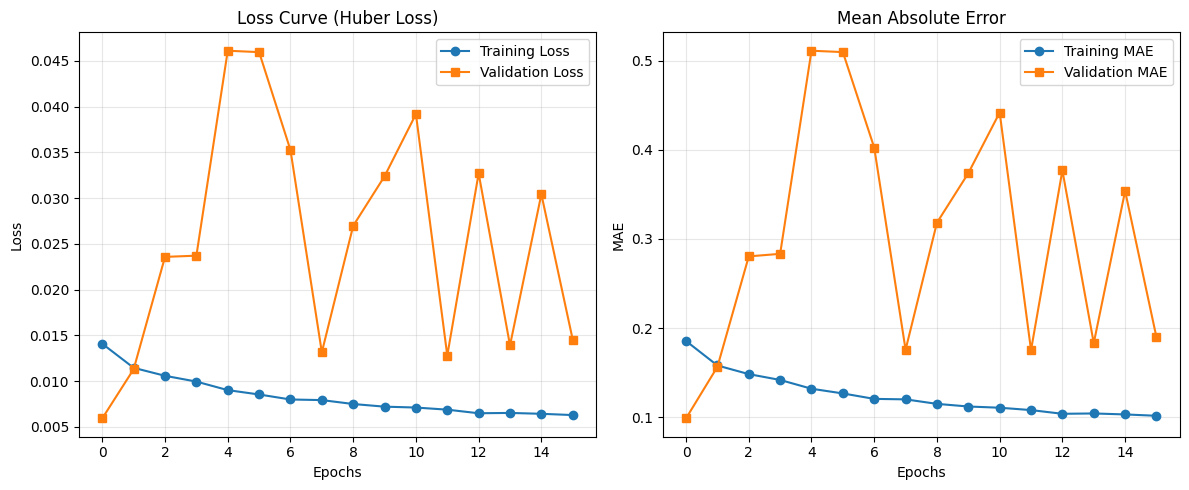

📊 Training Summary:
  Final Training Loss: 0.006303
  Final Validation Loss: 0.014539
  Final Training MAE: 0.101662
  Final Validation MAE: 0.189643
  Total Epochs: 16


In [14]:
import matplotlib.pyplot as plt

# Check if history exists (from training)
if 'history' in globals() and hasattr(history, 'history'):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    plt.legend()
    plt.title("Loss Curve (Huber Loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    
    # Plot MAE if available
    plt.subplot(1, 2, 2)
    if 'mae' in history.history:
        plt.plot(history.history['mae'], label='Training MAE', marker='o')
    if 'val_mae' in history.history:
        plt.plot(history.history['val_mae'], label='Validation MAE', marker='s')
    plt.legend()
    plt.title("Mean Absolute Error")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("📊 Training Summary:")
    if 'loss' in history.history:
        print(f"  Final Training Loss: {history.history['loss'][-1]:.6f}")
    if 'val_loss' in history.history:
        print(f"  Final Validation Loss: {history.history['val_loss'][-1]:.6f}")
    if 'mae' in history.history:
        print(f"  Final Training MAE: {history.history['mae'][-1]:.6f}")
    if 'val_mae' in history.history:
        print(f"  Final Validation MAE: {history.history['val_mae'][-1]:.6f}")
    print(f"  Total Epochs: {len(history.history.get('loss', []))}")
else:
    print("⚠️  Training history not found.")
    print("   This could mean:")
    print("   1. Training hasn't been run yet")
    print("   2. Training was interrupted before completion")
    print("   3. The 'history' variable was cleared")
    print("\n💡 To plot training history, you need to run the training cell first.")
    print("   Or load your saved model and evaluate it directly (see Cell 12).")


In [15]:
# Evaluate model performance on validation data
val_results = model.evaluate(X_val, y_val, verbose=1)
val_loss, val_mae, val_mse = val_results

# Convert normalized predictions back to pixel coordinates for interpretation
predictions = model.predict(X_val)
predictions_pixels = predictions * 201.0
y_val_pixels = y_val * 201.0

# Calculate distance error in pixels
distances = np.sqrt(np.sum((predictions_pixels - y_val_pixels)**2, axis=1))
mean_distance = np.mean(distances)
median_distance = np.median(distances)

print(f"\n✅ Validation Results:")
print(f"  Huber Loss: {val_loss:.4f}")
print(f"  MAE (normalized): {val_mae:.4f}")
print(f"  MSE (normalized): {val_mse:.4f}")
print(f"\n📏 Distance Error (in pixels):")
print(f"  Mean distance: {mean_distance:.2f} pixels")
print(f"  Median distance: {median_distance:.2f} pixels")
print(f"  Std deviation: {np.std(distances):.2f} pixels")
print(f"  95th percentile: {np.percentile(distances, 95):.2f} pixels")


29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 951ms/step - loss: 0.0062 - mae: 0.1013 - mse: 0.0168
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

✅ Validation Results:
  Huber Loss: 0.0059
  MAE (normalized): 0.0988
  MSE (normalized): 0.0160

📏 Distance Error (in pixels):
  Mean distance: 30.96 pixels
  Median distance: 27.89 pixels
  Std deviation: 18.22 pixels
  95th percentile: 66.07 pixels


29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


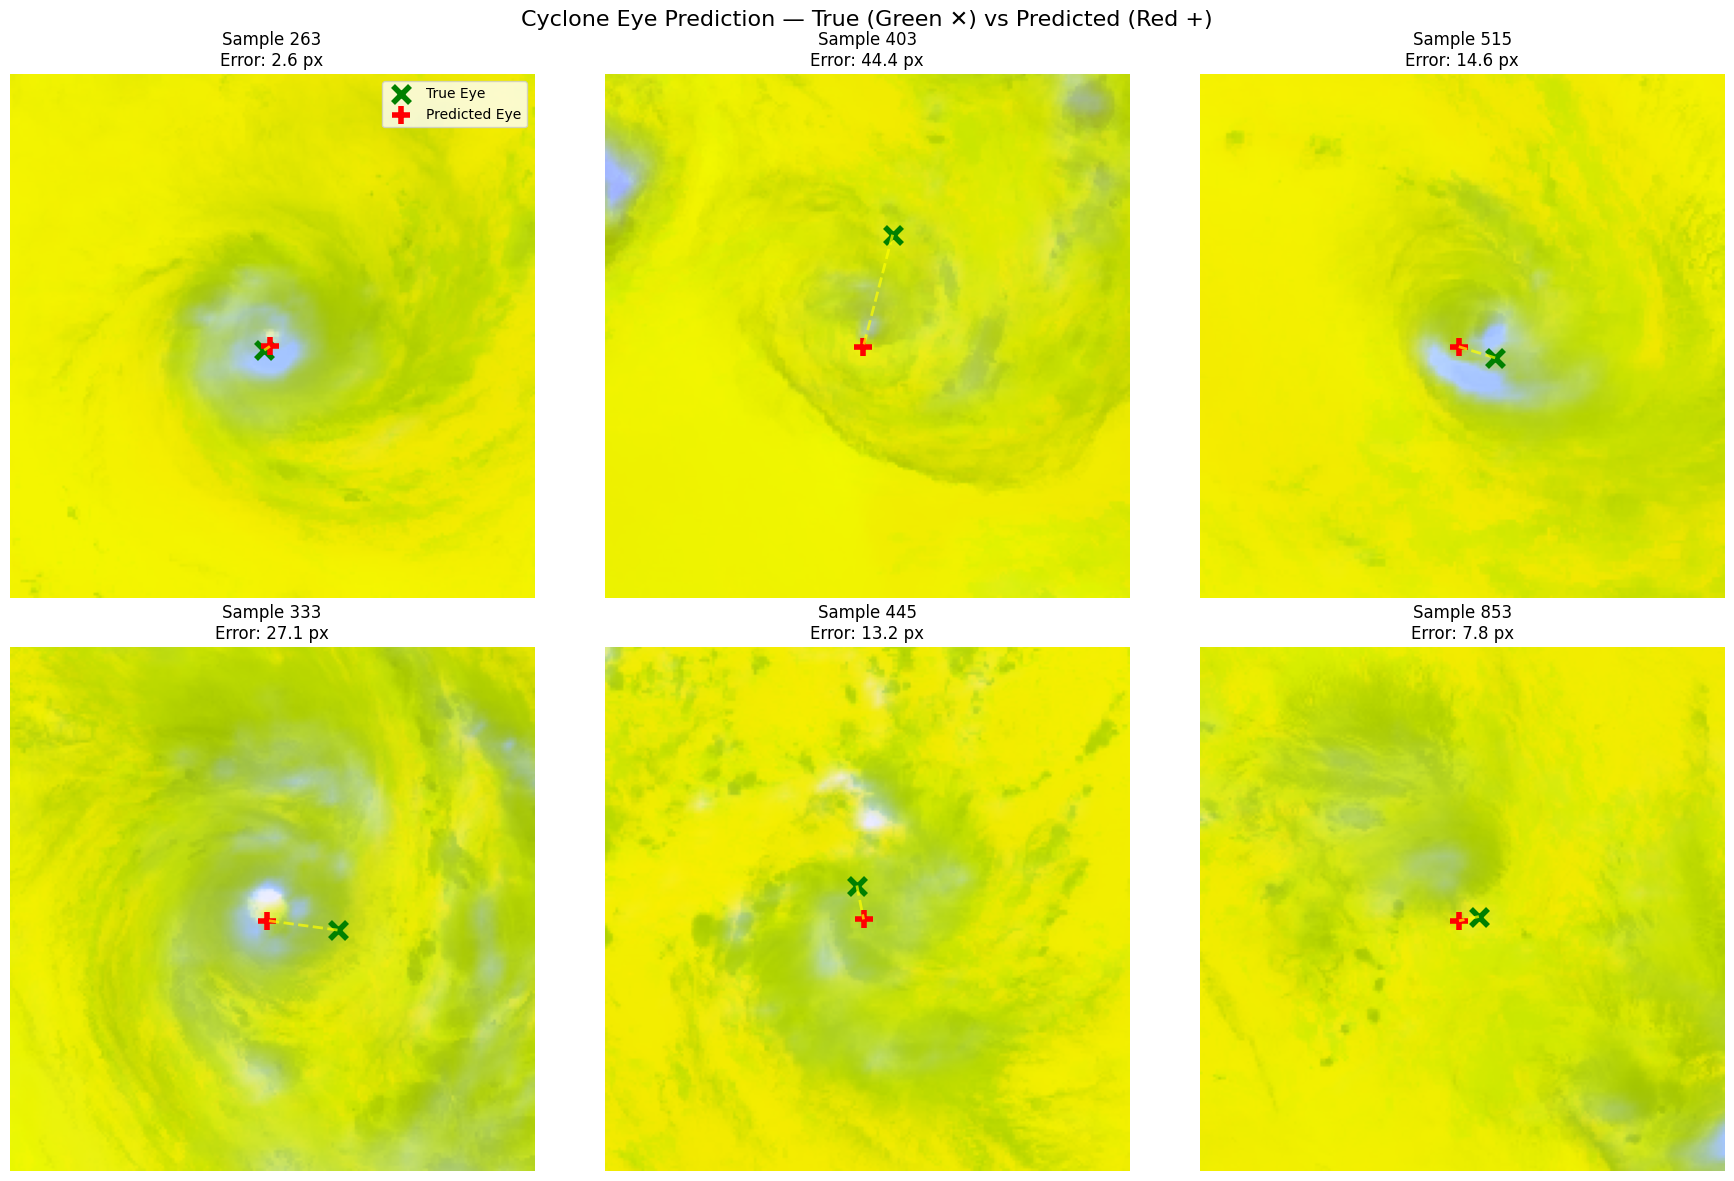

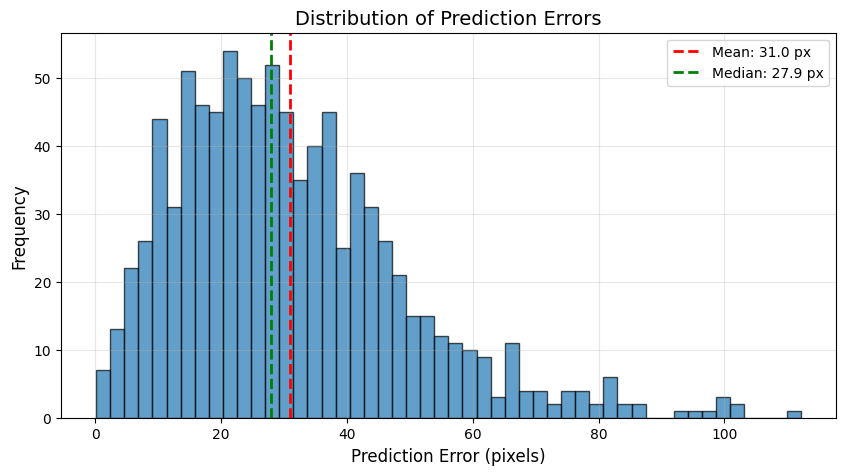

In [16]:
import random
import matplotlib.pyplot as plt

# Predict cyclone eye positions
preds = model.predict(X_val)

# Convert to pixel coordinates for visualization
preds_pixels = preds * 201.0
y_val_pixels = y_val * 201.0

# Visualize random samples with error metrics
num_samples = 6
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i in range(num_samples):
    idx = random.randint(0, len(X_val)-1)
    img = X_val[idx]
    true_x, true_y = y_val_pixels[idx]
    pred_x, pred_y = preds_pixels[idx]
    
    # Calculate error distance
    error = np.sqrt((pred_x - true_x)**2 + (pred_y - true_y)**2)

    axes[i].imshow(img)
    axes[i].scatter(true_x, true_y, color='green', label='True Eye', s=150, marker='x', linewidths=4)
    axes[i].scatter(pred_x, pred_y, color='red', label='Predicted Eye', s=150, marker='+', linewidths=4)
    axes[i].plot([true_x, pred_x], [true_y, pred_y], 'yellow', linewidth=2, alpha=0.7, linestyle='--')
    axes[i].set_title(f"Sample {idx}\nError: {error:.1f} px", fontsize=12)
    axes[i].axis('off')
    if i == 0:
        axes[i].legend(loc='upper right', fontsize=10)

plt.suptitle("Cyclone Eye Prediction — True (Green ✕) vs Predicted (Red +)", fontsize=16)
plt.tight_layout()
plt.show()

# Show error distribution
plt.figure(figsize=(10, 5))
distances = np.sqrt(np.sum((preds_pixels - y_val_pixels)**2, axis=1))
plt.hist(distances, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(mean_distance, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_distance:.1f} px')
plt.axvline(median_distance, color='green', linestyle='--', linewidth=2, label=f'Median: {median_distance:.1f} px')
plt.xlabel('Prediction Error (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_cyclone_eye(img_path, model):
    img = image.load_img(img_path, target_size=(201, 201))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0]
    return pred

# Example usage
test_path = r"C:\Users\beast\Downloads\archive (4)\insat3d_raw_cyclone_ds\CYCLONE_DATASET_FINAL\87.jpg"
pred = predict_cyclone_eye(test_path, model)
print("Predicted Cyclone Eye (x, y):", pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predicted Cyclone Eye (x, y): [0.46302435 0.5109993 ]


🎯 Cyclone Eye Detection - Image Visualization

💡 To visualize a prediction on your image, use:
   visualize_cyclone_prediction('path/to/your/image.jpg', model)

📝 Example usage:

✅ Processing image: 94.jpg


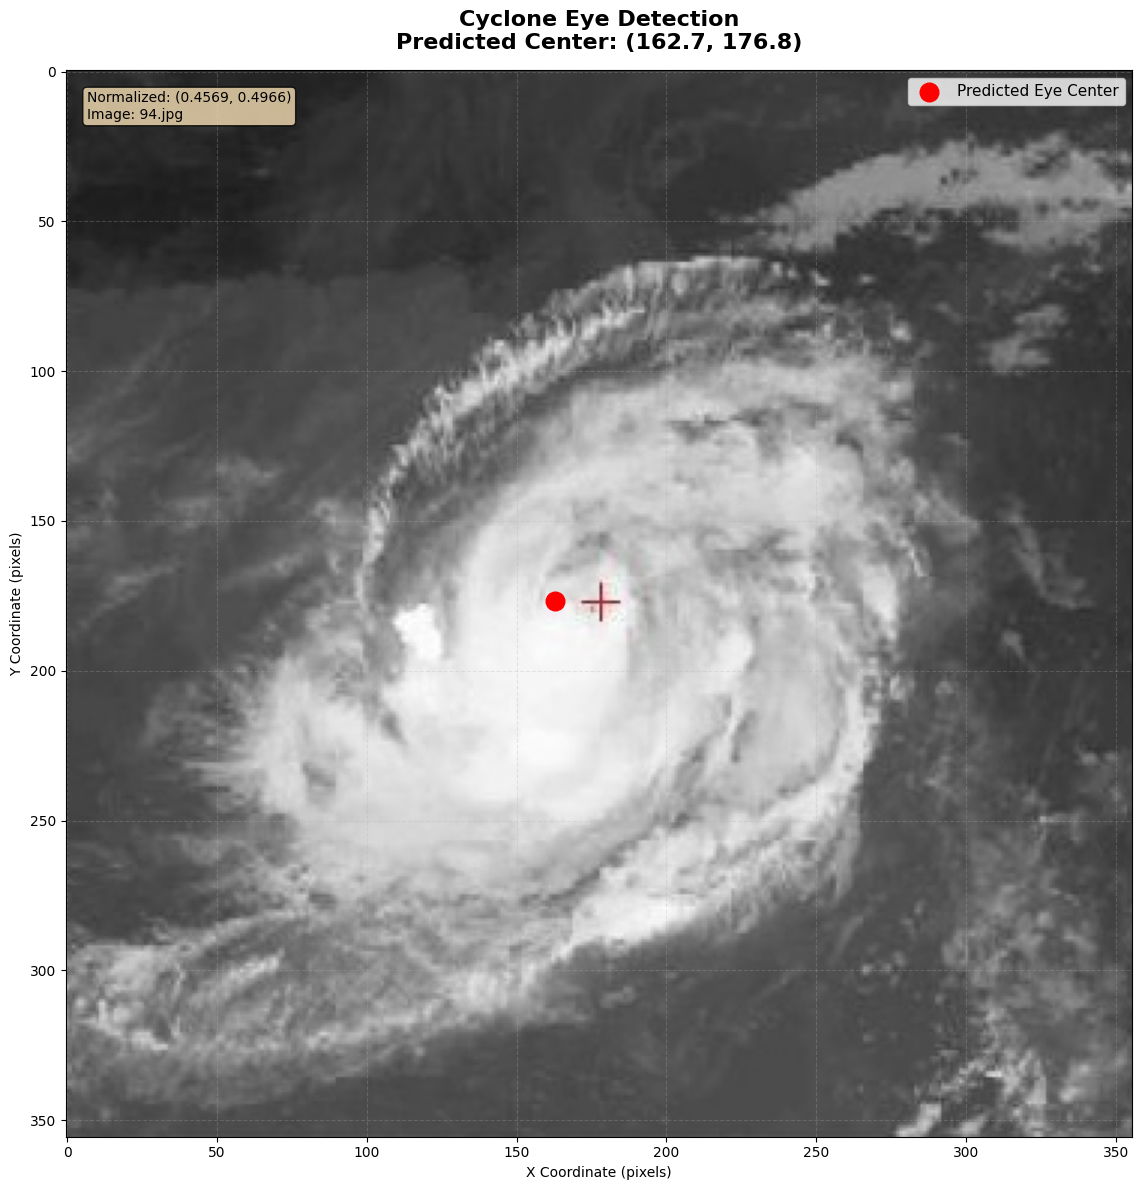


✅ Prediction Complete (High-Resolution Display)
   Image: 94.jpg
   Predicted Eye Center (Original Pixels): (162.7, 176.8)
   Normalized: (0.4569, 0.4966)


In [35]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def predict_cyclone_eye(img_path, model, img_size=(201, 201)):
    """
    Predict cyclone eye position from an image file.
    This function handles the same normalization as training data.
    
    Args:
        img_path: Path to the image file
        model: Trained model
        img_size: Target image size (width, height)
    
    Returns:
        pred_pixels: Predicted (x, y) coordinates in pixels
        pred_norm: Predicted (x, y) coordinates normalized [0, 1]
        img: The loaded image array (normalized)
        original_img: Original PIL image for display
    """
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    
    # Load and resize image
    original_img = Image.open(img_path)
    img = image.load_img(img_path, target_size=img_size)
    img_array = np.array(img, dtype=np.float32)
    
    # Normalize to [0, 1] range (same as training)
    if img_array.max() > 1.0:
        img_array = img_array / 255.0
    
    # Ensure 3 channels (handle grayscale and RGBA)
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]  # Take first 3 channels
    elif img_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels: {img_array.shape[2]}")
    
    img_array = np.expand_dims(img_array, axis=0)
    pred_norm = model.predict(img_array, verbose=0)[0]
    
    # Convert normalized prediction to pixel coordinates
    pred_pixels = pred_norm * img_size[0]  # Assuming square images
    
    return pred_pixels, pred_norm, img_array[0], original_img

def visualize_cyclone_prediction(img_path, model, img_size=(201, 201), figsize=(12, 10),
                                 save_path=None):

    try:
        # Predict on resized image (for model input)
        pred_pixels, pred_norm, img_array, original_img = predict_cyclone_eye(img_path, model, img_size)

        # Get original resolution
        orig_w, orig_h = original_img.size

        # Convert normalized prediction to original pixel coords
        x = pred_norm[0] * orig_w
        y = pred_norm[1] * orig_h

        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=figsize)

        # Display ORIGINAL IMAGE (not resized)
        display_img = np.array(original_img)
        ax.imshow(display_img)

        # Draw only a clean red dot
        ax.scatter([x], [y], color='red', s=180, marker='o', label='Predicted Eye Center')

        # Formatting
        ax.set_title(f"Cyclone Eye Detection\nPredicted Center: ({x:.1f}, {y:.1f})", 
                     fontsize=16, fontweight='bold', pad=15)
        ax.set_xlabel("X Coordinate (pixels)")
        ax.set_ylabel("Y Coordinate (pixels)")
        ax.grid(True, linestyle='--', alpha=0.25)
        ax.legend(loc='upper right', fontsize=11)

        # Info Box
        info_text = f"Normalized: ({pred_norm[0]:.4f}, {pred_norm[1]:.4f})\nImage: {os.path.basename(img_path)}"
        ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=200, bbox_inches='tight')
            print(f"✅ Saved to: {save_path}")

        plt.show()

        print("\n✅ Prediction Complete (High-Resolution Display)")
        print(f"   Image: {os.path.basename(img_path)}")
        print(f"   Predicted Eye Center (Original Pixels): ({x:.1f}, {y:.1f})")
        print(f"   Normalized: ({pred_norm[0]:.4f}, {pred_norm[1]:.4f})")

        return (x, y), pred_norm

    except Exception as e:
        print(f"❌ Error: {e}")
        raise


def predict_from_numpy(img_array, model, img_size=(201, 201)):
    """
    Predict cyclone eye from a numpy array (already normalized).
    Useful for predicting on data from the HDF5 file.
    
    Args:
        img_array: Image array of shape (201, 201, 3) or (H, W, 3), already normalized
        model: Trained model
        img_size: Expected image size (for coordinate conversion)
    
    Returns:
        pred_pixels: Predicted (x, y) coordinates in pixels
        pred_norm: Predicted (x, y) coordinates normalized [0, 1]
    """
    # Ensure correct shape
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)
    elif len(img_array.shape) != 4:
        raise ValueError(f"Expected 3D or 4D array, got shape: {img_array.shape}")
    
    # Ensure 3 channels
    if img_array.shape[-1] != 3:
        raise ValueError(f"Expected 3 channels, got {img_array.shape[-1]}")
    
    pred_norm = model.predict(img_array, verbose=0)
    if pred_norm.shape[0] == 1:
        pred_norm = pred_norm[0]
    
    pred_pixels = pred_norm * img_size[0]
    
    return pred_pixels, pred_norm

def visualize_prediction(img, pred_pixels, true_pixels=None, title="Cyclone Eye Prediction"):
    """
    Visualize prediction on an image.
    
    Args:
        img: Image array (normalized to [0,1] or [0,255])
        pred_pixels: Predicted (x, y) coordinates
        true_pixels: Optional true (x, y) coordinates for comparison
        title: Plot title
    """
    plt.figure(figsize=(10, 10))
    
    # Ensure image is in [0,1] range for display
    display_img = img.copy()
    if display_img.max() > 1.0:
        display_img = display_img / 255.0
    
    plt.imshow(display_img)
    plt.scatter(pred_pixels[0], pred_pixels[1], color='red', s=200, marker='x', 
                linewidths=4, label=f'Predicted ({pred_pixels[0]:.1f}, {pred_pixels[1]:.1f})')
    
    if true_pixels is not None:
        plt.scatter(true_pixels[0], true_pixels[1], color='green', s=200, marker='+', 
                    linewidths=4, label=f'True ({true_pixels[0]:.1f}, {true_pixels[1]:.1f})')
        # Draw line between true and predicted
        plt.plot([true_pixels[0], pred_pixels[0]], [true_pixels[1], pred_pixels[1]], 
                'yellow', linewidth=2, alpha=0.7, linestyle='--')
        error = np.sqrt((pred_pixels[0] - true_pixels[0])**2 + (pred_pixels[1] - true_pixels[1])**2)
        title += f" (Error: {error:.1f} px)"
    
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN VISUALIZATION FUNCTION - Use this to visualize predictions on your images!
# ============================================================================

print("🎯 Cyclone Eye Detection - Image Visualization")
print("=" * 70)
print("\n💡 To visualize a prediction on your image, use:")
print("   visualize_cyclone_prediction('path/to/your/image.jpg', model)")
print("\n📝 Example usage:")
print("=" * 70)

# Example: Visualize prediction on an image
# Replace this path with your image path
example_image_path = r"C:\Users\beast\Downloads\archive (4)\insat3d_raw_cyclone_ds\CYCLONE_DATASET_FINAL\94.jpg"

if os.path.exists(example_image_path):
    print(f"\n✅ Processing image: {os.path.basename(example_image_path)}")
    pred_pixels, pred_norm = visualize_cyclone_prediction(
        example_image_path,
        model,
        figsize=(14, 12)
    )
else:
    print(f"⚠️ Image not found")



In [20]:
# Batch prediction utility - predict on multiple images at once
import glob
from pathlib import Path

def batch_predict(image_paths, model, img_size=(201, 201), show_progress=True):
    """
    Predict cyclone eye positions for multiple images.
    
    Args:
        image_paths: List of image file paths or a directory path
        model: Trained model
        img_size: Target image size
        show_progress: Whether to show progress
    
    Returns:
        results: List of dicts with 'path', 'pred_pixels', 'pred_norm', 'img'
    """
    # Handle directory input
    if isinstance(image_paths, (str, Path)):
        if os.path.isdir(image_paths):
            image_paths = glob.glob(os.path.join(image_paths, '*.jpg')) + \
                         glob.glob(os.path.join(image_paths, '*.png')) + \
                         glob.glob(os.path.join(image_paths, '*.jpeg'))
        else:
            image_paths = [image_paths]
    
    results = []
    total = len(image_paths)
    
    for i, img_path in enumerate(image_paths):
        try:
            pred_pixels, pred_norm, img = predict_cyclone_eye(img_path, model, img_size)
            results.append({
                'path': img_path,
                'pred_pixels': pred_pixels,
                'pred_norm': pred_norm,
                'img': img,
                'success': True
            })
            if show_progress and (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{total} images...")
        except Exception as e:
            results.append({
                'path': img_path,
                'error': str(e),
                'success': False
            })
            if show_progress:
                print(f"⚠️  Error processing {img_path}: {e}")
    
    if show_progress:
        successful = sum(1 for r in results if r.get('success', False))
        print(f"\n✅ Completed: {successful}/{total} successful predictions")
    
    return results

def visualize_batch_predictions(results, num_samples=6, figsize=(18, 12)):
    """
    Visualize a batch of predictions.
    
    Args:
        results: List of result dicts from batch_predict
        num_samples: Number of samples to visualize
        figsize: Figure size
    """
    successful_results = [r for r in results if r.get('success', False)]
    
    if len(successful_results) == 0:
        print("⚠️  No successful predictions to visualize")
        return
    
    num_samples = min(num_samples, len(successful_results))
    selected = np.random.choice(len(successful_results), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    for idx, i in enumerate(selected):
        result = successful_results[i]
        img = result['img']
        pred_pixels = result['pred_pixels']
        filename = os.path.basename(result['path'])
        
        axes[idx].imshow(img)
        axes[idx].scatter(pred_pixels[0], pred_pixels[1], color='red', s=150, 
                         marker='x', linewidths=3)
        axes[idx].set_title(f"{filename}\n({pred_pixels[0]:.1f}, {pred_pixels[1]:.1f})", 
                           fontsize=10)
        axes[idx].axis('off')
    
    plt.suptitle("Batch Predictions - Cyclone Eye Detection", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example: Batch predict on a directory
print("💡 Batch prediction utility ready!")
print("\nExample usage:")
print("  # Predict on a directory")
print("  results = batch_predict('path/to/images/', model)")
print("  visualize_batch_predictions(results, num_samples=6)")
print("\n  # Predict on specific files")
print("  image_list = ['img1.jpg', 'img2.jpg', 'img3.jpg']")
print("  results = batch_predict(image_list, model)")


💡 Batch prediction utility ready!

Example usage:
  # Predict on a directory
  results = batch_predict('path/to/images/', model)
  visualize_batch_predictions(results, num_samples=6)

  # Predict on specific files
  image_list = ['img1.jpg', 'img2.jpg', 'img3.jpg']
  results = batch_predict(image_list, model)


In [21]:
# ============================================================================
# MODEL PARAMETERS DOCUMENTATION
# Use this to compare with other models and understand training configuration
# ============================================================================

import json
from datetime import datetime

def get_model_parameters(model, history=None):
    """
    Extract and document all model parameters for comparison with other models.
    Returns a comprehensive dictionary of all training and model parameters.
    """
    params = {
        "model_name": "ResNet50-based Cyclone Eye Detection",
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        
        # Dataset Information
        "dataset": {
            "total_samples": len(images) if 'images' in globals() else "N/A",
            "training_samples": len(X_train) if 'X_train' in globals() else "N/A",
            "validation_samples": len(X_val) if 'X_val' in globals() else "N/A",
            "test_split": 0.2,
            "image_size": "(201, 201, 3)",
            "label_format": "Normalized coordinates [0, 1]",
            "label_range": {
                "x_min": float(np.min(labels_norm[:, 0])) if 'labels_norm' in globals() else "N/A",
                "x_max": float(np.max(labels_norm[:, 0])) if 'labels_norm' in globals() else "N/A",
                "y_min": float(np.min(labels_norm[:, 1])) if 'labels_norm' in globals() else "N/A",
                "y_max": float(np.max(labels_norm[:, 1])) if 'labels_norm' in globals() else "N/A"
            }
        },
        
        # Model Architecture
        "architecture": {
            "base_model": "ResNet50 (ImageNet pretrained)",
            "input_shape": str(model.input_shape[1:]) if hasattr(model, 'input_shape') else "N/A",
            "output_shape": str(model.output_shape[1:]) if hasattr(model, 'output_shape') else "N/A",
            "total_layers": len(model.layers) if hasattr(model, 'layers') else "N/A",
            "trainable_layers": sum(1 for layer in model.layers if layer.trainable) if hasattr(model, 'layers') else "N/A",
            "frozen_layers": "First 145 layers (frozen)",
            "unfrozen_layers": "Last 30 layers (fine-tuned)",
            "backbone": {
                "name": "ResNet50",
                "pretrained": True,
                "weights": "ImageNet",
                "include_top": False
            },
            "head": {
                "type": "Custom Regression Head",
                "layers": [
                    {"type": "GlobalAveragePooling2D", "output_size": "2048"},
                    {"type": "Dense", "units": 1024, "activation": "relu"},
                    {"type": "BatchNormalization"},
                    {"type": "Dropout", "rate": 0.4},
                    {"type": "Dense", "units": 512, "activation": "relu"},
                    {"type": "BatchNormalization"},
                    {"type": "Dropout", "rate": 0.3},
                    {"type": "Dense", "units": 256, "activation": "relu"},
                    {"type": "Dropout", "rate": 0.2},
                    {"type": "Dense", "units": 2, "activation": "sigmoid"}
                ],
                "total_parameters": model.count_params() if hasattr(model, 'count_params') else "N/A"
            }
        },
        
        # Training Configuration
        "training": {
            "optimizer": {
                "type": "Adam",
                "learning_rate": 1e-4,
                "beta_1": 0.9,
                "beta_2": 0.999
            },
            "loss_function": {
                "type": "Huber Loss",
                "delta": 0.1,
                "description": "More robust to outliers than MSE"
            },
            "metrics": ["mae", "mse"],
            "batch_size": 32,
            "max_epochs": 50,
            "early_stopping": {
                "enabled": True,
                "monitor": "val_loss",
                "patience": 15,
                "min_delta": 1e-6,
                "restore_best_weights": True
            },
            "learning_rate_schedule": {
                "type": "ReduceLROnPlateau",
                "monitor": "val_loss",
                "factor": 0.5,
                "patience": 5,
                "min_lr": 1e-7
            },
            "model_checkpoint": {
                "enabled": True,
                "monitor": "val_loss",
                "save_best_only": True,
                "filename": "best_resnet50_model.h5"
            }
        },
        
        # Data Augmentation
        "augmentation": {
            "enabled": True,
            "rotation_range": 10,
            "width_shift_range": 0.1,
            "height_shift_range": 0.1,
            "horizontal_flip": False,
            "vertical_flip": False,
            "fill_mode": "nearest",
            "note": "No flipping to preserve cyclone structure"
        },
        
        # Training Results
        "results": {}
    }
    
    # Add training history if available
    if history and hasattr(history, 'history'):
        params["results"]["training_history"] = {
            "total_epochs": len(history.history.get('loss', [])),
            "final_training_loss": float(history.history['loss'][-1]) if 'loss' in history.history else "N/A",
            "final_validation_loss": float(history.history['val_loss'][-1]) if 'val_loss' in history.history else "N/A",
            "final_training_mae": float(history.history['mae'][-1]) if 'mae' in history.history else "N/A",
            "final_validation_mae": float(history.history['val_mae'][-1]) if 'val_mae' in history.history else "N/A",
            "best_epoch": int(np.argmin(history.history['val_loss'])) + 1 if 'val_loss' in history.history else "N/A",
            "best_val_loss": float(np.min(history.history['val_loss'])) if 'val_loss' in history.history else "N/A"
        }
    
    # Add validation metrics if available
    if 'X_val' in globals() and 'y_val' in globals():
        try:
            val_results = model.evaluate(X_val, y_val, verbose=0)
            if len(val_results) >= 3:
                params["results"]["validation"] = {
                    "loss": float(val_results[0]),
                    "mae": float(val_results[1]),
                    "mse": float(val_results[2])
                }
                
                # Calculate distance error
                predictions = model.predict(X_val, verbose=0)
                predictions_pixels = predictions * 201.0
                y_val_pixels = y_val * 201.0
                distances = np.sqrt(np.sum((predictions_pixels - y_val_pixels)**2, axis=1))
                
                params["results"]["validation"]["distance_error_pixels"] = {
                    "mean": float(np.mean(distances)),
                    "median": float(np.median(distances)),
                    "std": float(np.std(distances)),
                    "p95": float(np.percentile(distances, 95)),
                    "p99": float(np.percentile(distances, 99))
                }
        except:
            pass
    
    return params

# Generate and display model parameters
print("📊 MODEL PARAMETERS DOCUMENTATION")
print("=" * 70)

try:
    model_params = get_model_parameters(model, history if 'history' in globals() else None)
    
    # Display formatted output
    print("\n" + "=" * 70)
    print("MODEL INFORMATION")
    print("=" * 70)
    print(f"Model Name: {model_params['model_name']}")
    print(f"Timestamp: {model_params['timestamp']}")
    print(f"Total Parameters: {model_params['architecture']['head']['total_parameters']:,}")
    
    print("\n" + "=" * 70)
    print("ARCHITECTURE")
    print("=" * 70)
    print(f"Base Model: {model_params['architecture']['base_model']}")
    print(f"Input Shape: {model_params['architecture']['input_shape']}")
    print(f"Output Shape: {model_params['architecture']['output_shape']}")
    print(f"Trainable Layers: {model_params['architecture']['trainable_layers']}/{model_params['architecture']['total_layers']}")
    
    print("\n" + "=" * 70)
    print("TRAINING CONFIGURATION")
    print("=" * 70)
    print(f"Optimizer: {model_params['training']['optimizer']['type']}")
    print(f"Learning Rate: {model_params['training']['optimizer']['learning_rate']}")
    print(f"Loss Function: {model_params['training']['loss_function']['type']}")
    print(f"Batch Size: {model_params['training']['batch_size']}")
    print(f"Max Epochs: {model_params['training']['max_epochs']}")
    print(f"Early Stopping: {model_params['training']['early_stopping']['enabled']} (patience={model_params['training']['early_stopping']['patience']})")
    
    print("\n" + "=" * 70)
    print("DATA AUGMENTATION")
    print("=" * 70)
    aug = model_params['augmentation']
    print(f"Rotation Range: ±{aug['rotation_range']}°")
    print(f"Width Shift: ±{aug['width_shift_range']*100}%")
    print(f"Height Shift: ±{aug['height_shift_range']*100}%")
    print(f"Horizontal Flip: {aug['horizontal_flip']}")
    print(f"Vertical Flip: {aug['vertical_flip']}")
    
    if model_params['results']:
        print("\n" + "=" * 70)
        print("TRAINING RESULTS")
        print("=" * 70)
        if 'training_history' in model_params['results']:
            hist = model_params['results']['training_history']
            print(f"Total Epochs Trained: {hist['total_epochs']}")
            print(f"Best Epoch: {hist['best_epoch']}")
            print(f"Best Validation Loss: {hist['best_val_loss']:.6f}")
            print(f"Final Training Loss: {hist['final_training_loss']:.6f}")
            print(f"Final Validation Loss: {hist['final_validation_loss']:.6f}")
            print(f"Final Validation MAE: {hist['final_validation_mae']:.6f}")
        
        if 'validation' in model_params['results']:
            val = model_params['results']['validation']
            print(f"\nValidation Metrics:")
            print(f"  Loss: {val['loss']:.6f}")
            print(f"  MAE: {val['mae']:.6f}")
            if 'distance_error_pixels' in val:
                dist = val['distance_error_pixels']
                print(f"\nDistance Error (pixels):")
                print(f"  Mean: {dist['mean']:.2f}")
                print(f"  Median: {dist['median']:.2f}")
                print(f"  Std Dev: {dist['std']:.2f}")
                print(f"  95th Percentile: {dist['p95']:.2f}")
    
    # Save to JSON file for easy comparison
    output_file = 'model_parameters.json'
    with open(output_file, 'w') as f:
        json.dump(model_params, f, indent=2)
    print(f"\n✅ Model parameters saved to: {output_file}")
    print("   Use this file to compare with other models!")
    
except Exception as e:
    print(f"⚠️  Error generating parameters: {e}")
    print("   Make sure the model is loaded and training has been completed.")


📊 MODEL PARAMETERS DOCUMENTATION

MODEL INFORMATION
Model Name: ResNet50-based Cyclone Eye Detection
Timestamp: 2025-11-07 07:50:16
Total Parameters: 26,348,674

ARCHITECTURE
Base Model: ResNet50 (ImageNet pretrained)
Input Shape: (201, 201, 3)
Output Shape: (2,)
Trainable Layers: 40/185

TRAINING CONFIGURATION
Optimizer: Adam
Learning Rate: 0.0001
Loss Function: Huber Loss
Batch Size: 32
Max Epochs: 50
Early Stopping: True (patience=15)

DATA AUGMENTATION
Rotation Range: ±10°
Width Shift: ±10.0%
Height Shift: ±10.0%
Horizontal Flip: False
Vertical Flip: False

TRAINING RESULTS
Total Epochs Trained: 16
Best Epoch: 1
Best Validation Loss: 0.005945
Final Training Loss: 0.006303
Final Validation Loss: 0.014539
Final Validation MAE: 0.189643

Validation Metrics:
  Loss: 0.005945
  MAE: 0.098784

Distance Error (pixels):
  Mean: 30.96
  Median: 27.89
  Std Dev: 18.22
  95th Percentile: 66.07

✅ Model parameters saved to: model_parameters.json
   Use this file to compare with other models!


In [24]:
# ============================================================================
# COMPREHENSIVE MODEL EVALUATION - For Comparison with Other Models
# ============================================================================
# This cell calculates all regression and detection metrics similar to the 
# reference model for easy comparison.

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 70)

# Check prerequisites
if 'model' not in globals():
    print("❌ Error: Model not found. Please run Cell 9 to build the model.")
    raise NameError("Model not defined")

if 'X_val' not in globals() or 'y_val' not in globals():
    print("❌ Error: Validation data not found. Please run data loading cells (2-7).")
    raise NameError("Validation data (X_val, y_val) not defined")

# Get predictions
print("\n📊 Making predictions on validation set...")
y_pred = model.predict(X_val, verbose=0)

# Convert to pixel coordinates for distance calculations
img_size = 201  # Image size
y_val_pixels = y_val * img_size
y_pred_pixels = y_pred * img_size

# ============================================================================
# REGRESSION METRICS
# ============================================================================
print("\n" + "=" * 70)
print("REGRESSION METRICS")
print("=" * 70)

# Calculate metrics on normalized coordinates
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Calculate max error manually (max_error doesn't support multioutput)
# Max error is the maximum Euclidean distance between true and predicted points
distances_normalized = np.sqrt(np.sum((y_val - y_pred)**2, axis=1))
max_err = np.max(distances_normalized)

# Convert max error to pixels
max_err_pixels = max_err * img_size

print(f"MSE (Mean Squared Error):        {mse:.2f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.2f}")
print(f"MAE (Mean Absolute Error):       {mae:.2f}")
print(f"R2 Score:                        {r2:.3f}")
print(f"Max Error (pixels):              {max_err_pixels:.2f}")

# ============================================================================
# DETECTION METRICS (Based on Pixel Distance Thresholds)
# ============================================================================
print("\n" + "=" * 70)
print("DETECTION METRICS")
print("=" * 70)

def calculate_detection_metrics(y_true_pixels, y_pred_pixels, threshold):
    """
    Calculate detection metrics for a given pixel distance threshold.
    For cyclone eye detection, we consider a prediction 'correct' if it's 
    within threshold pixels of the true eye center.
    """
    # Calculate Euclidean distance for each prediction
    distances = np.sqrt(np.sum((y_true_pixels - y_pred_pixels)**2, axis=1))
    
    # True Positives: predictions within threshold
    tp = np.sum(distances <= threshold)
    
    # False Positives: predictions outside threshold
    fp = len(y_true_pixels) - tp
    
    # False Negatives: 0 (we always make a prediction for each image)
    fn = 0
    
    # Calculate metrics
    accuracy = (tp / len(y_true_pixels)) * 100 if len(y_true_pixels) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    }

# Calculate metrics for different thresholds
thresholds = [1, 5, 10, 20]

print("\nThreshold-based Detection Metrics:")
print("-" * 70)

for threshold in thresholds:
    metrics = calculate_detection_metrics(y_val_pixels, y_pred_pixels, threshold)
    
    print(f"\nAccuracy within ±{threshold} pixels: {metrics['accuracy']:.2f}%")
    print(f"  Precision: {metrics['precision']:.2f}")
    print(f"  Recall:    {metrics['recall']:.2f}")
    print(f"  F1-score:  {metrics['f1_score']:.2f}")

# ============================================================================
# SUMMARY TABLE
# ============================================================================
print("\n" + "=" * 70)
print("SUMMARY TABLE FOR COMPARISON")
print("=" * 70)

print("\nRegression Metrics:")
print(f"  MSE:  {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE:  {mae:.2f}")
print(f"  R2:   {r2:.3f}")
print(f"  Max Error (pixels): {max_err_pixels:.2f}")

print("\nDetection Metrics:")
for threshold in thresholds:
    metrics = calculate_detection_metrics(y_val_pixels, y_pred_pixels, threshold)
    print(f"  ±{threshold}px: Accuracy={metrics['accuracy']:.2f}%, "
          f"Precision={metrics['precision']:.2f}, "
          f"Recall={metrics['recall']:.2f}, "
          f"F1={metrics['f1_score']:.2f}")

# ============================================================================
# SAVE METRICS TO FILE FOR COMPARISON
# ============================================================================
import json
from datetime import datetime

metrics_dict = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "regression_metrics": {
        "mse": float(mse),
        "rmse": float(rmse),
        "mae": float(mae),
        "r2_score": float(r2),
        "max_error_pixels": float(max_err_pixels)
    },
    "detection_metrics": {}
}

for threshold in thresholds:
    metrics = calculate_detection_metrics(y_val_pixels, y_pred_pixels, threshold)
    metrics_dict["detection_metrics"][f"threshold_{threshold}px"] = {
        "accuracy_percent": float(metrics['accuracy']),
        "precision": float(metrics['precision']),
        "recall": float(metrics['recall']),
        "f1_score": float(metrics['f1_score'])
    }

# Save to JSON
output_file = "model_evaluation_metrics.json"
with open(output_file, 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"\n✅ Evaluation metrics saved to: {output_file}")
print("   Use this file to compare with other models!")

print("\n" + "=" * 70)
print("✅ Evaluation Complete!")
print("=" * 70)


COMPREHENSIVE MODEL EVALUATION

📊 Making predictions on validation set...

REGRESSION METRICS
MSE (Mean Squared Error):        0.02
RMSE (Root Mean Squared Error):  0.13
MAE (Mean Absolute Error):       0.10
R2 Score:                        -0.173
Max Error (pixels):              112.12

DETECTION METRICS

Threshold-based Detection Metrics:
----------------------------------------------------------------------

Accuracy within ±1 pixels: 0.33%
  Precision: 0.00
  Recall:    1.00
  F1-score:  0.01

Accuracy within ±5 pixels: 2.29%
  Precision: 0.02
  Recall:    1.00
  F1-score:  0.04

Accuracy within ±10 pixels: 9.06%
  Precision: 0.09
  Recall:    1.00
  F1-score:  0.17

Accuracy within ±20 pixels: 30.79%
  Precision: 0.31
  Recall:    1.00
  F1-score:  0.47

SUMMARY TABLE FOR COMPARISON

Regression Metrics:
  MSE:  0.02
  RMSE: 0.13
  MAE:  0.10
  R2:   -0.173
  Max Error (pixels): 112.12

Detection Metrics:
  ±1px: Accuracy=0.33%, Precision=0.00, Recall=1.00, F1=0.01
  ±5px: Accuracy